In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import torch
from transformers import *
from xgboost import plot_importance
from matplotlib import pyplot as plt
import pickle

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Training

In [4]:
df=pd.read_csv('/home/spideysloth/keywords.csv')
df=df.dropna()

## Bert Embeddings for the Keywords

In [44]:
%%time
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased')]

for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    outputs=[]
    for keyword in df.Keyword:
        inputs=[tokenizer.encode(keyword,add_special_tokens=True)]
        input_ids = torch.tensor(inputs)  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
        with torch.no_grad():
            last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
            outputs.append((last_hidden_states.data.cpu().numpy()))

I0928 00:00:02.382734 140393517258496 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/spideysloth/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0928 00:00:02.920999 140393517258496 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/spideysloth/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I0928 00:00:02.922475 140393517258496 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_n

CPU times: user 1h 24min 37s, sys: 5.75 s, total: 1h 24min 43s
Wall time: 1h 24min 43s


In [11]:
# # Saving the computed Embeddings as a pickle file
# # Bert Computed 768 embeddings for every word in keyword
pickle_out = open("fin.pickle","wb")
pickle.dump(outputs, pickle_out)
pickle_out.close()

In [13]:
with open('./fin.pickle', 'rb') as f:
    outputs = pickle.load(f)

In [14]:
# Computing Mean and Median of the Embeddings 
means=[]
for output in outputs:
    means.append(np.mean(output))

medians=[]
for output in outputs:
    medians.append(np.median(output))

## Directly Predicting Clicks

In [33]:
df=pd.read_csv('/home/spideysloth/keywords.csv')
df=df.dropna()
df["Mean"]=means
df["Median"]=medians

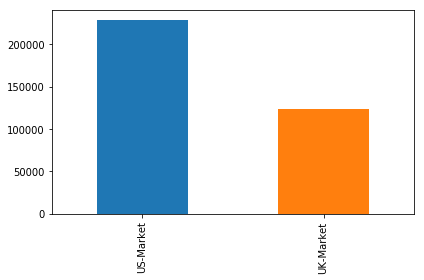

In [16]:
pd.value_counts(df['Market']).plot.bar()
plt.tight_layout()
# plt.savefig('/home/spideysloth/market_imbalance.png')

In [17]:
# Random Sampling To combat the uneven Data
newdf=pd.concat([y.sample(100000,replace=True) for _, y in df.groupby('Market')])
df=pd.concat([df,newdf[newdf.Market=="UK-Market"]])

In [18]:
# Encoding the Market
market_encoder = LabelEncoder()
df["Market"] = market_encoder.fit_transform(df["Market"])


# Spliting the Date into spearate Day,Month,Year
df["Date"]=df.Date.astype(str)
df["Year"]=df.Date.str[:4]
df["Month"]=df.Date.str[4:6]
df["Day"]=df.Date.str[6:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)

In [34]:
# Normalizing CPC
print(df["CPC"].mean(),df["CPC"].std())
df["CPC"]=(df["CPC"]-df["CPC"].mean())/df["CPC"].std()

14.287964259374515 37.88243555215708


In [422]:
# df=df[np.abs(df.Clicks-df.Clicks.mean()) <= (1*df.Clicks.std())] #Only keep -3 to +3 std values of Energy

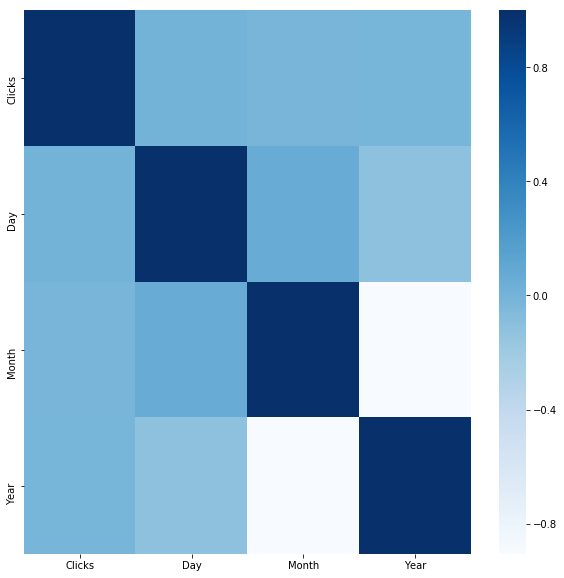

In [497]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(df[["Clicks","Day","Month","Year"]].corr(),ax=ax,cmap="Blues")
plt.savefig('/home/spideysloth/heatmap_dates.png')

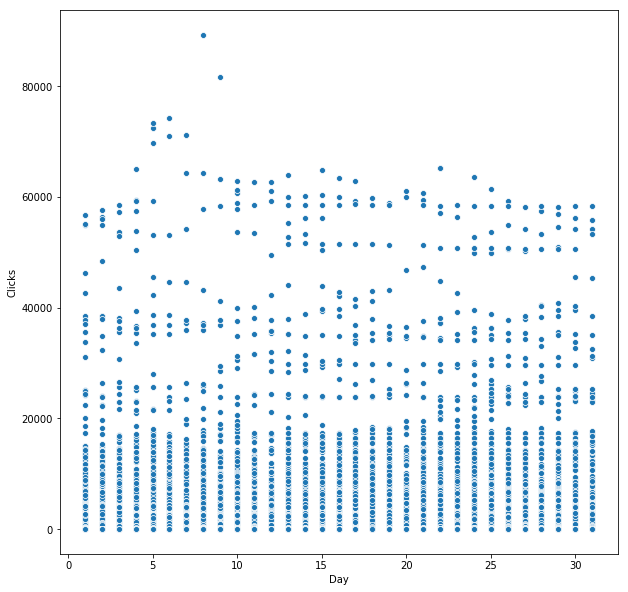

In [501]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(y="Clicks",x="Day",data=df,ax=ax)
plt.savefig('/home/spideysloth/scatter_day.png')

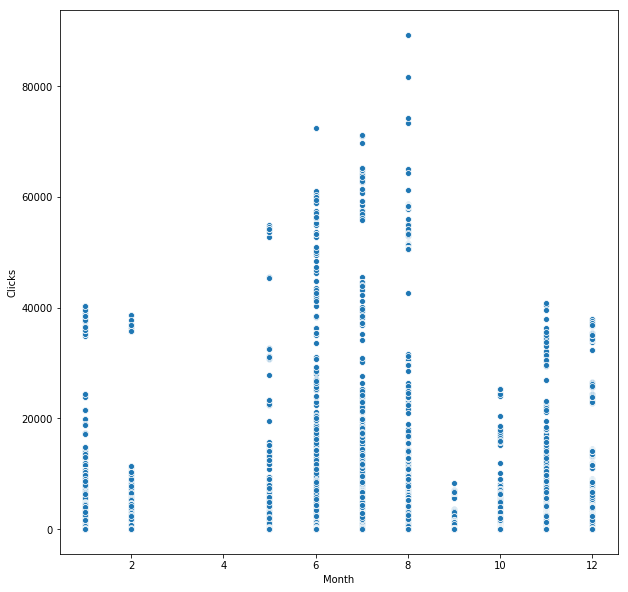

In [502]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(y="Clicks",x="Month",data=df)
plt.savefig('/home/spideysloth/scatter_Month.png')

In [20]:
y=df["Clicks"]
test_df=df[["Market","CPC","Mean","Median","Year","Month","Day"]]

In [21]:
test_df.head(2)

,Market,CPC,Mean,Median,Year,Month,Day
0,1,-0.373981,-0.012423,0.003567,2012,5,24
1,1,-0.341916,-0.013216,-0.000298,2012,5,24


In [22]:
# Spliting Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(test_df,y,test_size=0.3)

### Extra Trees 

In [35]:
from sklearn.ensemble import ExtraTreesRegressor
clf = ExtraTreesRegressor(verbose=1,max_depth=12,n_estimators=50,bootstrap=True,max_features='auto')
clf.fit(X_train,Y_train)
ypred=clf.predict(X_test)
print (sklearn.metrics.mean_absolute_error(Y_test.values,ypred))
print (sklearn.metrics.mean_squared_error(Y_test.values,ypred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


152.32258986665673
563791.4495399948


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


### XG Boost

In [24]:
from math import sqrt
eset = [(X_train, Y_train), (X_test, Y_test)]
xg_reg = xgboost.XGBRegressor(learning_rate = 0.1,early_stopping_rounds=10,max_depth = 25, n_estimators = 60,verbose=True,eval_metric=["mae","rmse"], eval_set=eset)
xg_reg.fit(X_train,Y_train,eval_set=eset)
ypred=xg_reg.predict(X_test)
ypred[ypred<0]=0.0
print (sklearn.metrics.mean_absolute_error(Y_test.values,ypred))
print (sqrt(sklearn.metrics.mean_squared_error(Y_test.values,ypred)))

[0]	validation_0-mae:162.878	validation_0-rmse:1399.59	validation_1-mae:164.575	validation_1-rmse:1371.68
[1]	validation_0-mae:147.261	validation_0-rmse:1268.12	validation_1-mae:148.903	validation_1-rmse:1244.78
[2]	validation_0-mae:133.163	validation_0-rmse:1149.61	validation_1-mae:134.819	validation_1-rmse:1131.1
[3]	validation_0-mae:120.463	validation_0-rmse:1042.8	validation_1-mae:122.168	validation_1-rmse:1029.12
[4]	validation_0-mae:109.012	validation_0-rmse:946.529	validation_1-mae:110.855	validation_1-rmse:938.744
[5]	validation_0-mae:98.6741	validation_0-rmse:859.85	validation_1-mae:100.678	validation_1-rmse:858.061
[6]	validation_0-mae:89.3651	validation_0-rmse:781.687	validation_1-mae:91.5136	validation_1-rmse:785.458
[7]	validation_0-mae:80.9897	validation_0-rmse:710.814	validation_1-mae:83.3846	validation_1-rmse:721.709
[8]	validation_0-mae:73.4143	validation_0-rmse:646.996	validation_1-mae:76.0293	validation_1-rmse:664.433
[9]	validation_0-mae:66.5909	validation_0-rmse:58

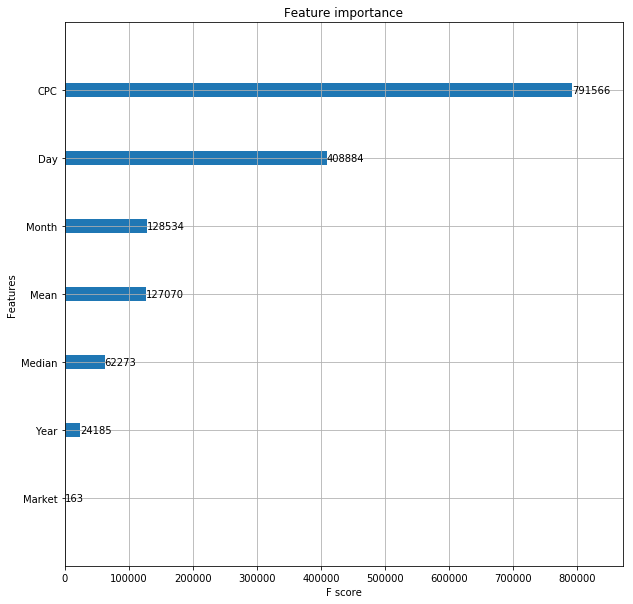

In [518]:
fig,ax=plt.subplots(figsize=(10,10))
plot_importance(xg_reg,ax=ax)

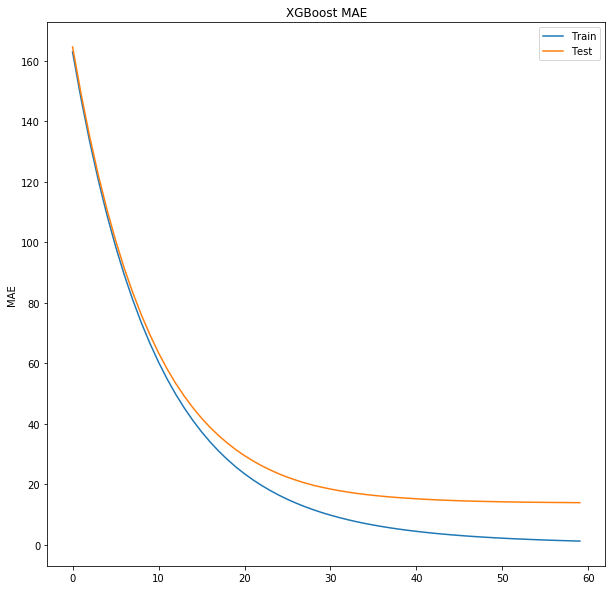

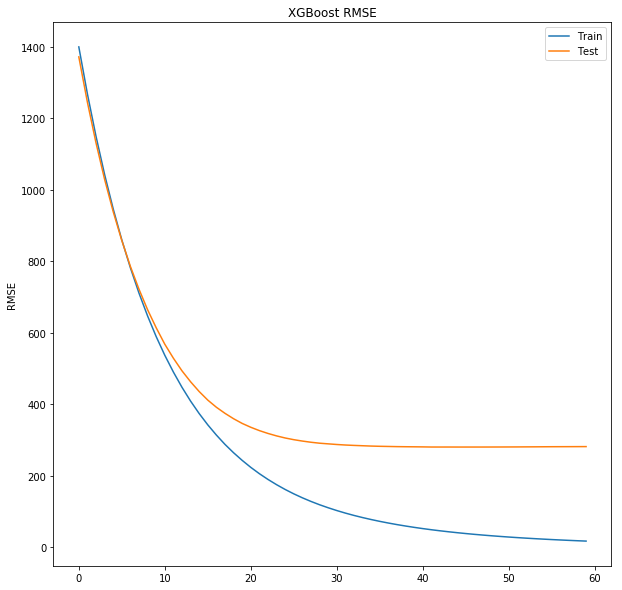

In [25]:
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost MAE')
# plt.savefig('/home/spideysloth/mae.png')
plt.show()

# # plot classification error
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
# plt.savefig('/home/spideysloth/rmse.png')
plt.show()

In [29]:
# Exporting the Model
import joblib
joblib.dump(xg_reg,'./xg_boost_final.sav')

['./xg_boost_final.sav']